In [28]:
%matplotlib inline

Comparison of training a hardware efficient ansatz with a global cost function and the gadget equivalent

Necessary imports

In [29]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import datetime

from gadget_utils import hardware_efficient_ansatz, cat_state_preparation

np.random.seed(42)

Defining the relevant parameters of the simulation

In [30]:
computational_qubits = 4
ancillary_qubits = 4
num_layers = 2
max_iter = 500
# num_samples = 200
perturbation_factor = 0.5
locality = computational_qubits
lambda_max = (locality - 1) / (4 * locality)

Global cost function
--------

creating the quantum device with the right number of qubits

In [31]:
dev_comp = qml.device("default.qubit", wires=range(computational_qubits))

creating the qunode using the imported methods

In [32]:
def computational_circuit(angles, measured_qubits):
    assert(len(np.shape(angles)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(angles)[1]
    if total_qubits > measured_qubits:
        # /!\ keep the 'ancillary_qubits = ' (has to be a keyword argument)
        cat_state_preparation(ancillary_qubits = range(measured_qubits, total_qubits, 1))
    hardware_efficient_ansatz(angles)
    H = np.zeros((2**measured_qubits, 2**measured_qubits))
    H[0, 0] = 1
    return qml.expval(qml.Hermitian(H, [i for i in range(measured_qubits)]))

computational_qnode = qml.QNode(computational_circuit, dev_comp)

(defining the cost function)

In [33]:
def computational_cost_function(angles, computational_qubits):
    return 1 - computational_qnode(angles, computational_qubits)

Choosing an optimizer

In [34]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

Initializing the parameters

In [35]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
cost_computational = [computational_cost_function(weights_init, computational_qubits)]

Optimization loop

In [36]:
weights = weights_init
for it in range(max_iter):
    # /!\ keyword arguments are not trained? don't know why but don't remove the 'computational_qubits='
    # keyword arguments are not wrapped https://discuss.pennylane.ai/t/wire-error-on-ibm-simulator/1282
    weights = opt.step(computational_cost_function, weights, computational_qubits=computational_qubits)
    cost_computational.append(computational_cost_function(weights, computational_qubits))
    # opt.update_stepsize(stepsize)
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_computational[-1]))


Iteration =     1 | Cost function =  0.99644841
Iteration =    51 | Cost function =  0.99999715
Iteration =   101 | Cost function =  0.99572352
Iteration =   151 | Cost function =  0.99593191
Iteration =   201 | Cost function =  0.94646454
Iteration =   251 | Cost function =  0.94906961
Iteration =   301 | Cost function =  0.98307339
Iteration =   351 | Cost function =  0.79437404
Iteration =   401 | Cost function =  0.90682507
Iteration =   451 | Cost function =  0.99256560


Saving and plotting the results

In [37]:
with open('../../results/data/{}_training_global_{}qubits_{}layers_{}iterations.dat'
            .format(datetime.datetime.now().strftime("%y%m%d"),
                    computational_qubits, num_layers, max_iter), 'w') as of:
    of.write('# iteration\tcost\n')

    for it in range(max_iter+1):
        of.write('{}\t{}\n'.format(it, cost_computational[it]))

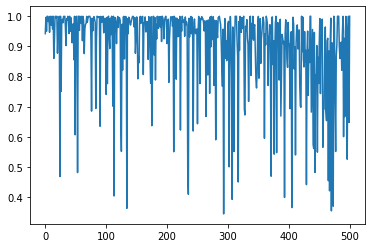

In [38]:
plt.plot(np.arange(max_iter+1), cost_computational)
plt.show()

Local cost function
--------

In [39]:
def local_circuit(angles):
    assert(len(np.shape(angles)) == 2)                  # check proper dimensions of params
    total_qubits = np.shape(angles)[1]
    hardware_efficient_ansatz(angles)
    H = np.zeros((2, 2))
    H[0, 0] = 1
    return qml.expval(qml.Hermitian(H, [0]))

local_qnode = qml.QNode(local_circuit, dev_comp)

In [40]:
def local_cost_function(angles, computational_qubits):
    return 1 - local_qnode(angles)

In [41]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [42]:
weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits), requires_grad=True)
cost_local = [local_cost_function(weights_init, computational_qubits)]

In [43]:
weights = weights_init
for it in range(max_iter):
    weights = opt.step(local_cost_function, weights, computational_qubits=computational_qubits)
    cost_local.append(local_cost_function(weights, computational_qubits))
    if it % 50 == 0:
        print("Iteration = {:5d} | Cost function = {: .8f}".format(it+1, cost_local[-1]))


Iteration =     1 | Cost function =  0.46305897
Iteration =    51 | Cost function =  0.73275455
Iteration =   101 | Cost function =  0.05599075
Iteration =   151 | Cost function =  0.00817811
Iteration =   201 | Cost function =  0.78138212
Iteration =   251 | Cost function =  0.86705591
Iteration =   301 | Cost function =  0.85402709
Iteration =   351 | Cost function =  0.14644661
Iteration =   401 | Cost function =  0.14644661
Iteration =   451 | Cost function =  0.80730342


In [44]:
with open('../../results/data/{}_training_local_{}qubits_{}layers_{}iterations.dat'
            .format(datetime.datetime.now().strftime("%y%m%d"),
                    computational_qubits, num_layers, max_iter), 'w') as of:
    of.write('# iteration\tcost\n')

    for it in range(max_iter+1):
        of.write('{}\t{}\n'.format(it, cost_local[it]))

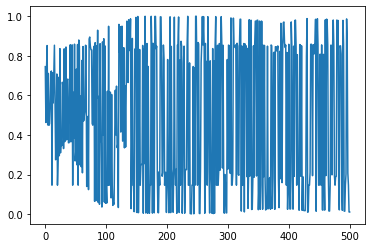

In [45]:
plt.plot(np.arange(max_iter+1), cost_local)
plt.show()

Gadget cost function
--------

In [46]:
# dev_gad = qml.device("default.qubit", wires=range(computational_qubits+ancillary_qubits))

In [47]:
# def gadget_circuit(params, computational_qubits):       # also working for k'-local 
#     assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
#     total_qubits = np.shape(params)[1]
#     cat_state_preparation(ancillary_qubits = range(computational_qubits, total_qubits, 1))
#     hardware_efficient_ansatz(params)

In [48]:
# @qml.qnode(dev_gad)
# def unperturbed_qnode(params, computational_qubits, target_qubits):
#     gadget_circuit(params, computational_qubits)
#     term = qml.Identity(target_qubits[0]) @ qml.Identity(target_qubits[1]) - qml.PauliZ(target_qubits[0]) @ qml.PauliZ(target_qubits[1])
#     return qml.expval(term)


# @qml.qnode(dev_gad)
# def perturbation_qnode(params, computational_qubits, target_qubits):
#     gadget_circuit(params, computational_qubits)
#     term = qml.PauliZ(target_qubits[0]) @ qml.PauliX(computational_qubits+target_qubits[0])
#     return qml.expval(term)


# def gadget_cost_function(params, computational_qubits):
#     assert(len(np.shape(params)) == 2)                  # check proper dimensions of params
#     total_qubits = np.shape(params)[1]
#     expectation_value = 0
#     # creating the "unperturbed Hamiltonian"
#     # acting on the ancillary qubits only
#     for first_qubit in range(computational_qubits, total_qubits):
#         for second_qubit in range(first_qubit+1, total_qubits):
#             expectation_value += unperturbed_qnode(params, computational_qubits, [first_qubit, second_qubit])
#     # creating the perturbation part of the Hamiltonian
#     # acting on both ancillary and target qubits with the same index
#     for qubit in range(computational_qubits):           # /!\ only valid for 2-local
#         expectation_value += perturbation_factor * lambda_max * perturbation_qnode(params, computational_qubits, [qubit])
#     return expectation_value

In [49]:
# control_qnode = qml.QNode(computational_circuit, dev_gad)
# def control_cost_function(params, computational_qubits):
#     return control_qnode(params, computational_qubits)

In [50]:
# opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [51]:
# weights_init = np.random.uniform(0, np.pi, size=(num_layers, computational_qubits+ancillary_qubits), requires_grad=True)
# cost_computational = [control_cost_function(weights_init, computational_qubits=computational_qubits)]
# cost_gadget = [gadget_cost_function(weights_init, computational_qubits)]


In [52]:
# weights = weights_init
# for it in range(max_iter):
#     weights, prev_cost = opt.step_and_cost(gadget_cost_function, weights, computational_qubits=computational_qubits)
#     cost_computational.append(control_cost_function(weights, computational_qubits))
#     cost_gadget.append(gadget_cost_function(weights, computational_qubits))
#     # opt.update_stepsize(stepsize)
#     if it % 10 == 0:
#         print(f"Iteration = {it:5d} | " +
#                "Gadget cost = {:.8f} | ".format(cost_gadget[-1]) +
#                "Computational cost = {:.8f}".format(cost_computational[-1]))


In [53]:
# with open('../../results/data/{}_training_gadget_{}qubits_{}layers_{}iterations_{}lambda.dat'
#             .format(datetime.datetime.now().strftime("%y%m%d"),
#                     computational_qubits, num_layers, max_iter, perturbation_factor), 'w') as of:
#     of.write('# iteration\tcost\n')

#     for it in range(max_iter+1):
#         of.write('{}\t{}\n'.format(it, cost_computational[it]))

In [54]:
# fig, ax = plt.subplots()
# ax.plot(np.arange(max_iter+1), cost_gadget, label=r'$\langle \psi_{HE}| H^{gad} |\psi_{HE} \rangle$')
# ax.plot(np.arange(max_iter+1), cost_computational, label=r'$\langle \psi_{HE}| H^{comp} |\psi_{HE} \rangle$')
# ax.set_xlabel(r"Number of iterations")
# ax.set_ylabel(r"Cost function")
# ax.legend()
# ax.set_title(r"$n_{comp}=$"+"{}".format(computational_qubits))
# plt.show()